## Data and Package Importing

In [1]:
from QC import *
from ml_utils import reorder_adata, gf_icf, recipe_fcc
sc.settings.set_figure_params(dpi=80)

In [ ]:
# reload fcc module while working
import sys
del sys.modules['ml_utils']
from ml_utils import *

### Load data and preprocess

Read in normal human colon sample

In [2]:
%time s1 = sc.read('3247-AS-1-GCCAAT_S1_counts.tsv.gz')

CPU times: user 1min 34s, sys: 8.78 s, total: 1min 42s
Wall time: 1min 44s


In [3]:
%%time
# quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
reorder_adata(s1)

# create new "observations" as percent and mean mito genes
s1.var['mito'] = s1.var_names.str.contains('MT-') # identify mitochondrial genes
s1.obs['mean_mito'] = np.mean(s1[:,s1.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(s1, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var

# rank cells by total counts and save as .obs
s1.obs['ranked_total_counts'] = np.argsort(s1.obs['total_counts'])

CPU times: user 11 s, sys: 7.25 s, total: 18.3 s
Wall time: 19.9 s


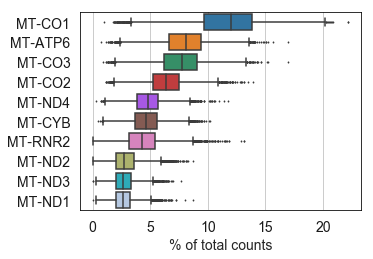

In [4]:
# look at highest expression by gene across all cells
sc.pl.highest_expr_genes(s1, n_top=10)

Looks like a lot of dead cells (high mitochondrial counts).

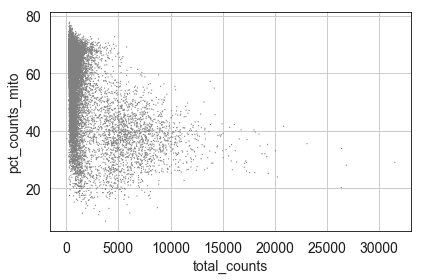

In [5]:
# look at low-quality and dead cell distribution
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito')

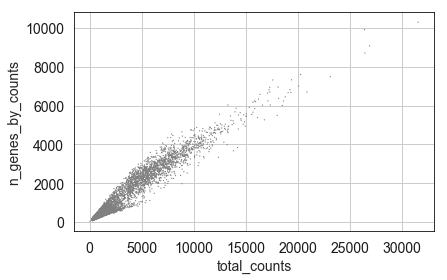

In [6]:
sc.pl.scatter(s1, x='total_counts', y='n_genes_by_counts')

### Find inflection point

Inflection point at bcEGRW     3541
bcIJCL     2348
bcBEDN     7392
bcEFCU    10593
bcDZKU    19127
Name: total_counts, dtype: int64 for [0, 15, 30, 50, 100] percentiles of greatest secant distances


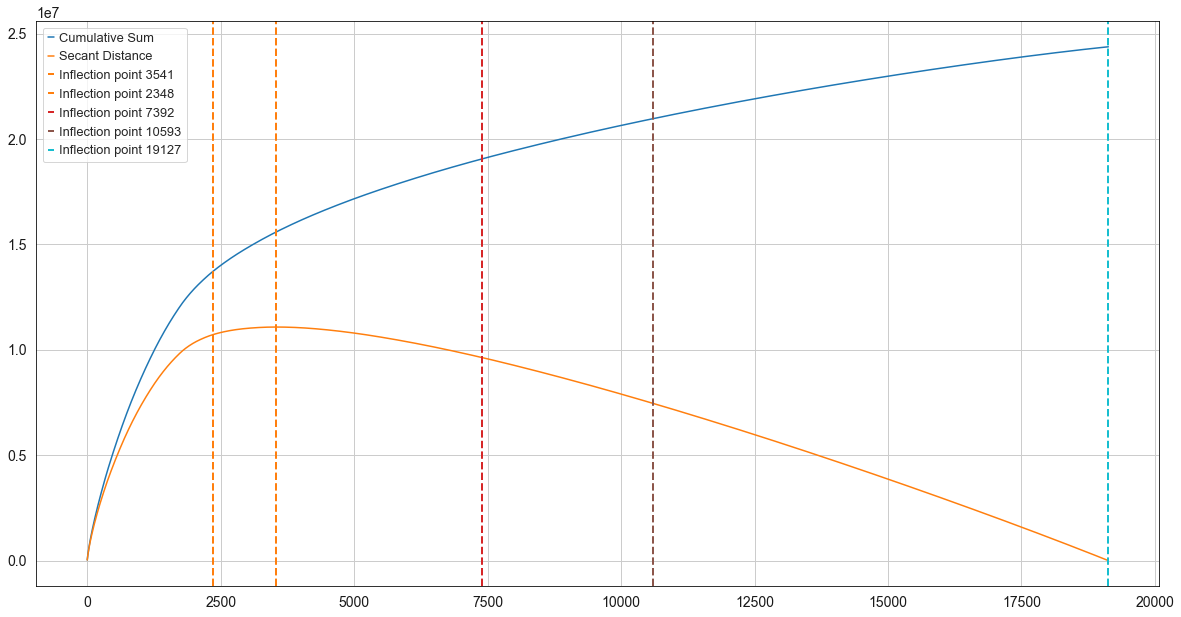

In [7]:
find_inflection(s1, inflection_percentiles = [0,15,30,50,100])

In [8]:
s1.obs['total_counts'][7392] # see the total counts for the cutoff point

682.0

Cutoff for `emptyDrops` should be at the number of counts above.   
Let's read in  `emptyDrops` predictions and filter out, then ID dead cells.

In [9]:
emptydrops = pd.read_csv('3247-AS-1-GCCAAT_S1_emptydrops.csv')
emptydrops.index = emptydrops['barcode']

In [11]:
# create new "observation" as empty droplet label
s1.obs['empty'] = emptydrops['empty']

In [12]:
# filter cells out based on minimum quality and save to new adata object
%time s1_notempty = sc.pp.filter_cells(s1, min_counts=682, copy=True)

CPU times: user 3.09 s, sys: 5.03 s, total: 8.12 s
Wall time: 9.5 s


In [13]:
# look at shape and attributes of filtered adata object
# there may be more than the given number of cells depending on cells with the same total_counts value
s1_notempty

AnnData object with n_obs × n_vars = 7399 × 41569 
    obs: 'mean_mito', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'empty', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Normalize and perform linear dimensionality reduction with PCA

In [14]:
%%time
sc.pp.normalize_total(s1_notempty, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1_notempty) # log1p transformation
sc.pp.scale(s1_notempty, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 2.47 s, sys: 570 ms, total: 3.04 s
Wall time: 3.09 s


In [15]:
# checkpoint normalized and scaled data for future visualizations
s1_notempty.raw = s1_notempty

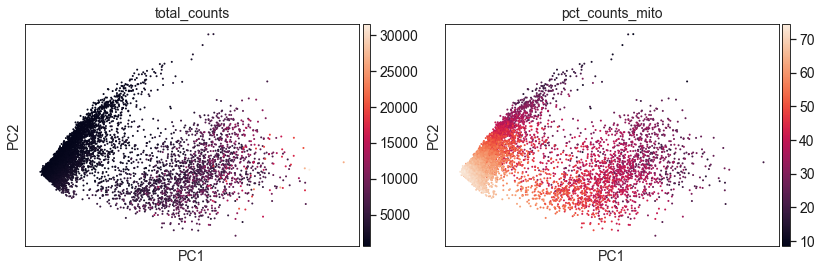

CPU times: user 28.8 s, sys: 2.02 s, total: 30.9 s
Wall time: 17.4 s


In [16]:
%%time
sc.tl.pca(s1_notempty, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1_notempty, color=['total_counts','pct_counts_mito'], ncols=2)

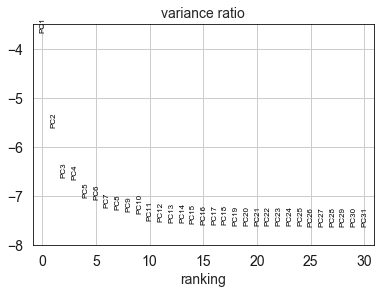

In [17]:
sc.pl.pca_variance_ratio(s1_notempty, log=True) #examine amount of variance captured by each principal component

### Non-linear dimensionality reduction with UMAP

In [18]:
%%time
sc.pp.neighbors(s1_notempty, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.umap(s1_notempty, random_state=1) # perform UMAP

/Users/cody/.virtualenvs/couscous/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../.virtualenvs/couscous/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/cody/.virtualenvs/couscous/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../.virtualenvs/couscous/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/cody/.virtualenvs/couscous/lib/python3.7/site-packages/numba/compiler

CPU times: user 20.6 s, sys: 764 ms, total: 21.4 s
Wall time: 21.3 s


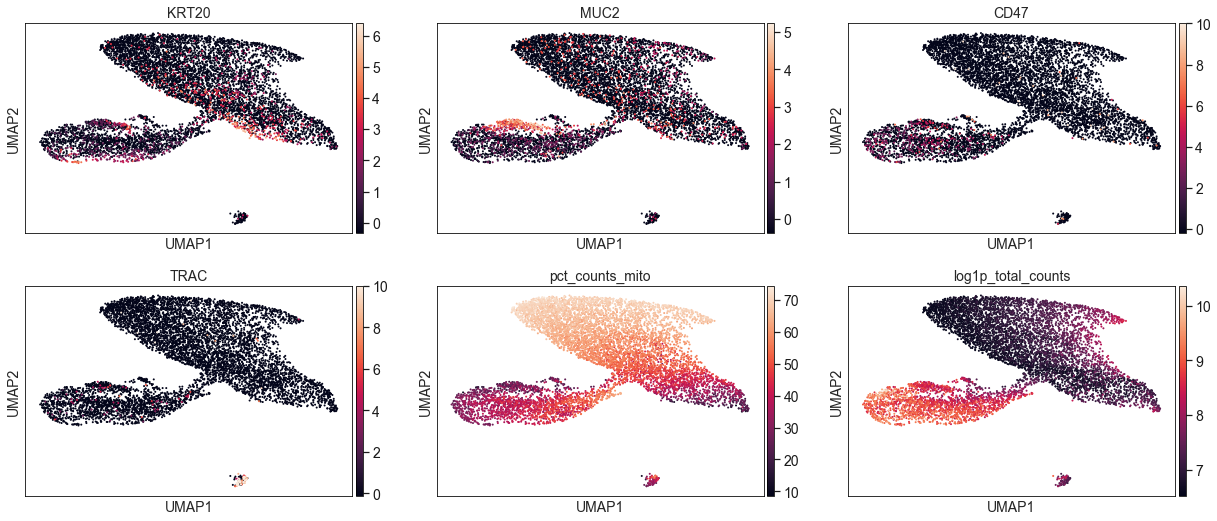

In [19]:
sc.pl.umap(s1_notempty, color=['KRT20','MUC2','CD47','TRAC','pct_counts_mito','log1p_total_counts'], ncols=3) # plot marker genes to determine which clusters to keep or gate out

### Clustering

In [20]:
sc.tl.louvain(s1_notempty, resolution=1.5, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

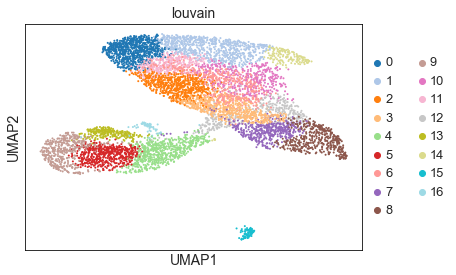

In [22]:
sc.pl.umap(s1_notempty, color=['louvain'], palette='tab20')

### Cluster quantification and non-parametric testing of gene expression profiles for gating

In [23]:
%time cluster_summary_stats(s1_notempty, raw=False) # in this case it's after normalization, but if you want to find these statistics for the raw counts, set the raw parameter to True

In [24]:
cluster_wilcoxon_rank_sum(s1_notempty, ['KRT20','MUC2','CD47','TRAC','pct_counts_mito','log1p_total_counts'], alternative='greater') 
#this takes a list of features that exist in the normalized representation of the data and performs a wilcoxon rank sum test between each cluster against the global counterparts of those data.
#these features can be single genes or compiled 'metagenes' such as the percent_mito and the mean_mito, as long as their values can be accessed in the AnnData object by using the .obs_vector method
#the "alternative" parameter is passed to scipy's "mann-whitney u" to designate the sidedness of the test, in this case the default is a one-sided hypothesis for values greater than the null.

In [25]:
cluster_p_threshold(s1_notempty, 0.05)
#this takes the p-values calculated above (per cluster) and simply returns a binarized output (0 or 1) that can be visualized
#the output represents wether or not the cluster has a p-value below the set threshold (0.05 in this case) 

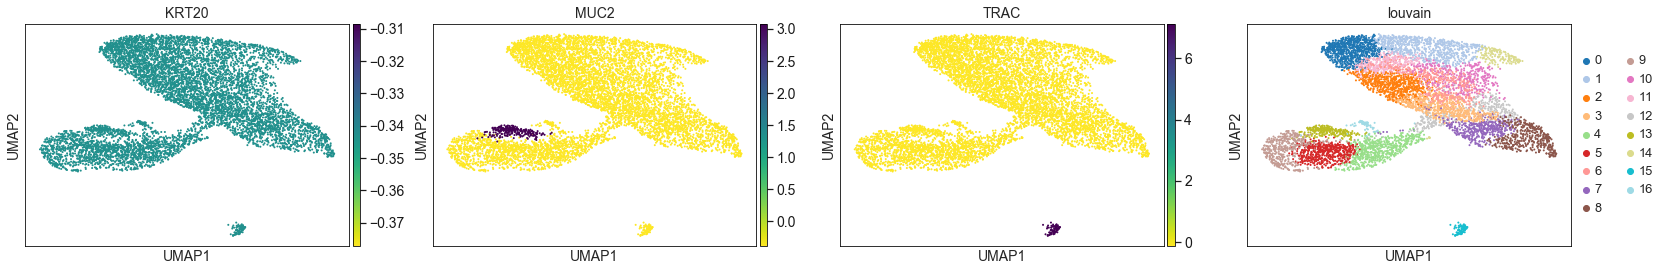

In [26]:
sc.pl.umap(s1_notempty, color=['KRT20','MUC2','TRAC','louvain'], color_map='viridis_r', layer='Cluster_Medians') 
# cluster medians per feature

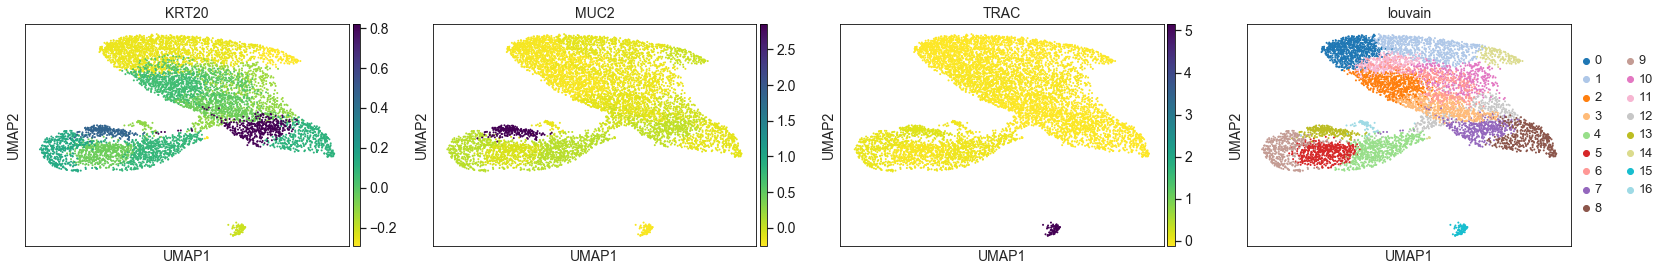

In [27]:
sc.pl.umap(s1_notempty, color=['KRT20','MUC2','TRAC','louvain'], color_map='viridis_r', layer='Cluster_Means') 
# cluster means per feature≤

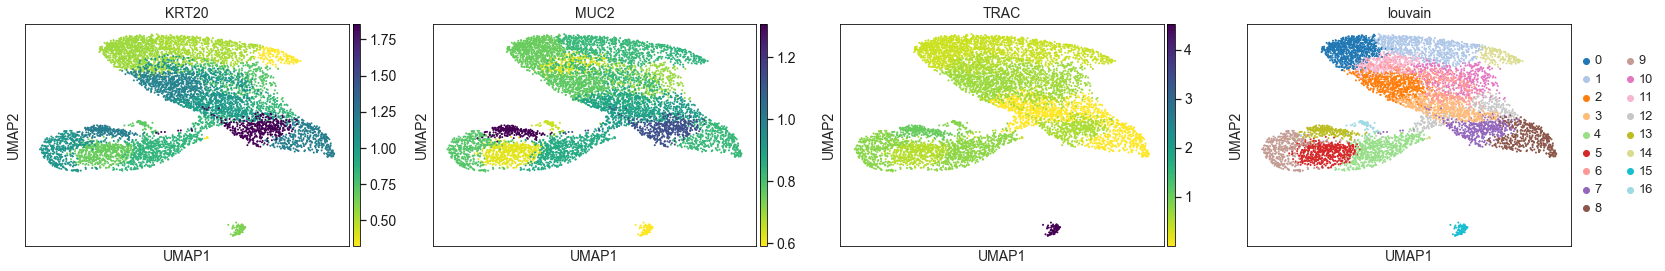

In [28]:
sc.pl.umap(s1_notempty, color=['KRT20','MUC2','TRAC','louvain'], color_map='viridis_r', layer='Cluster_Stdevs') 
# cluster stdevs per feature

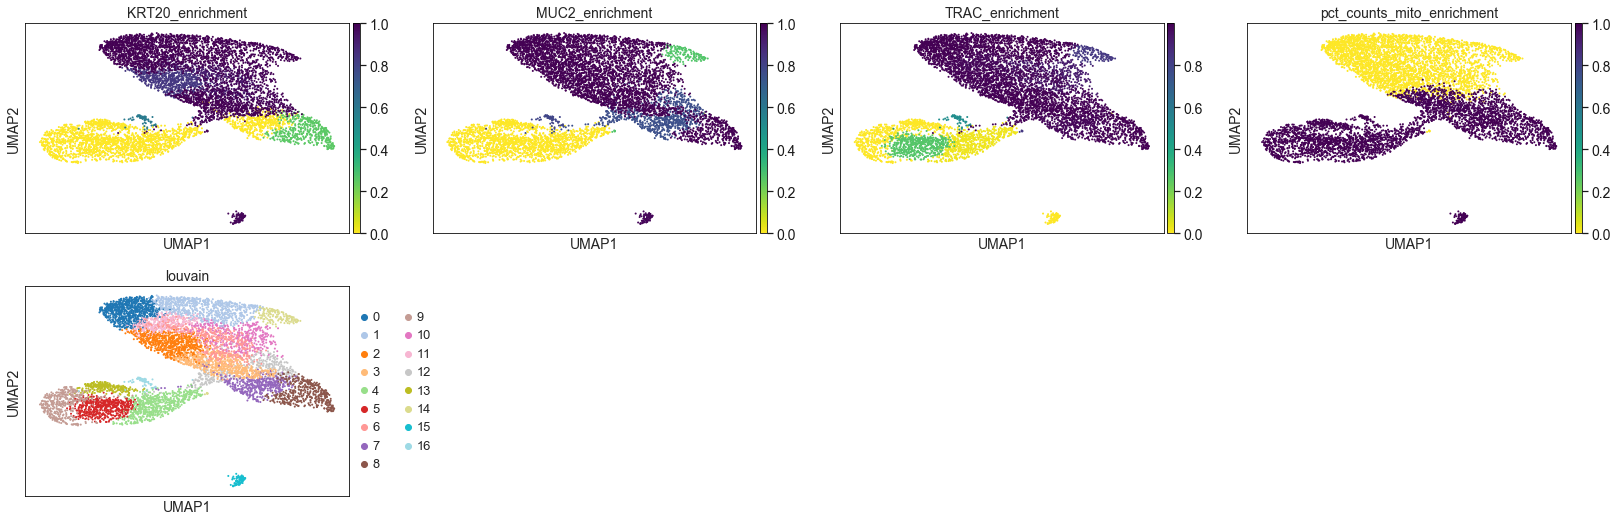

In [30]:
sc.pl.umap(s1_notempty, color=['KRT20_enrichment','MUC2_enrichment','TRAC_enrichment','pct_counts_mito_enrichment','louvain'], color_map='viridis_r')
# these are simply the p-values resulting from the features/featuresets tested, this visualization just shows a continuum of p-values per cluster given that test

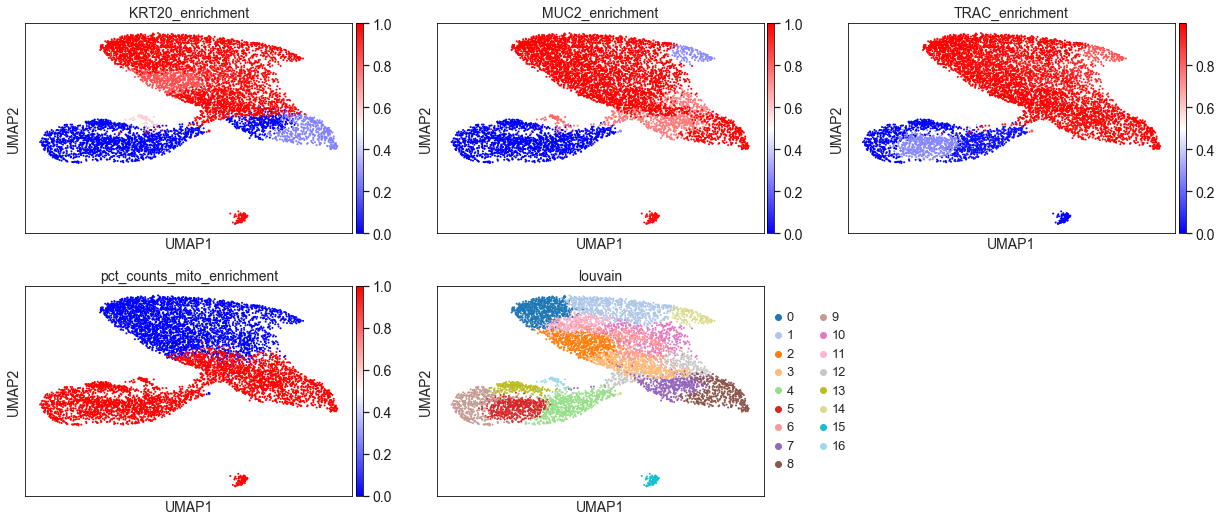

In [32]:
sc.pl.umap(s1_notempty, color=['KRT20_enrichment','MUC2_enrichment','TRAC_enrichment','pct_counts_mito_enrichment','louvain'], color_map = 'bwr', ncols=3)
# similar to above, but with significance threholded at 0.05 as per the example, this gives us a better idea of which louvain clusters to gate out based off of statistical bases

The above overlays are simply to guide the louvain cluster gating process by providing more quantitative and statistically robust methods for determining which clusters to gate out  

In [34]:
to_keep = np.where(s1_notempty.obs['louvain'].isin(['3','4','5','7','8','9','12','13','15','16']))[0] # fill in the indices of the clusters you want to keep here
# we choose these to keep because all other clusters have a significant enrichment for mitochondrial genes or hematopoetic cells

In [47]:
filtered = sc.AnnData(s1[to_keep,:]) # subsetting the original data to make a filtered dataset, here, we subset the raw (.raw) count data for our new object/QC'd dataset

In [48]:
filtered

AnnData object with n_obs × n_vars = 3902 × 41569 
    obs: 'mean_mito', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'empty'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

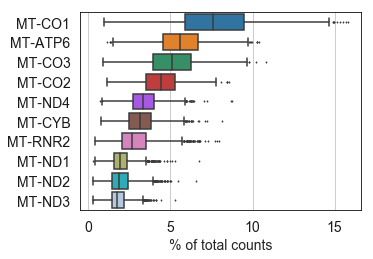

In [49]:
# look at highest expression by gene across all cells
sc.pl.highest_expr_genes(filtered, n_top=10)

Looks like a lot of dead cells (high mitochondrial counts).

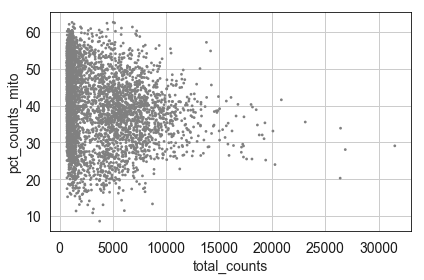

In [50]:
# look at low-quality and dead cell distribution
sc.pl.scatter(filtered, x='total_counts', y='pct_counts_mito')

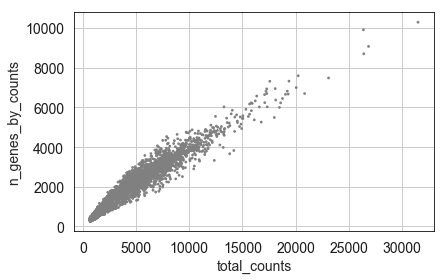

In [51]:
sc.pl.scatter(filtered, x='total_counts', y='n_genes_by_counts')

### Find inflection point

Inflection point at bcFWEG    1641
bcEPLP    1316
bcGXNJ    1005
bcEJAA    2587
bcDZKU    3901
Name: total_counts, dtype: int64 for [0, 15, 30, 50, 100] percentiles of greatest secant distances


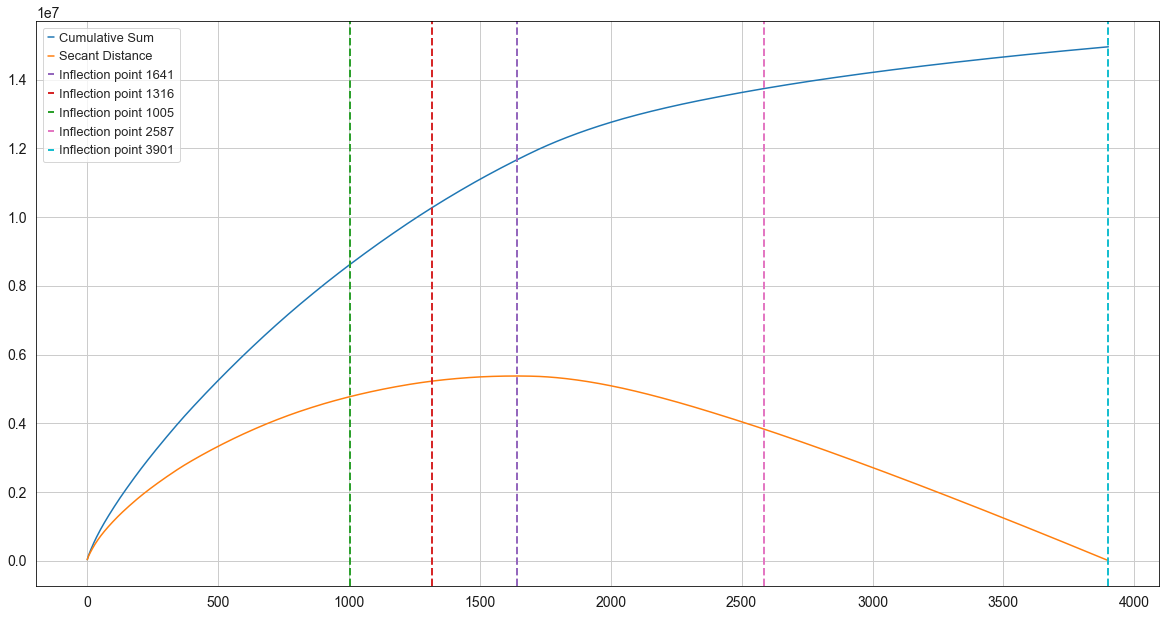

In [52]:
find_inflection(filtered, inflection_percentiles = [0,15,30,50,100])

In [53]:
filtered.obs['total_counts'][3901] # see the total counts for the cutoff point

682.0

### Normalize and perform linear dimensionality reduction with PCA

In [56]:
filtered.X

ArrayView([[-0.00185172, -0.00052174, -0.00531616, ..., -0.00116579,
             0.        ,  0.45671973],
           [-0.00185172, -0.00052174, -0.00531616, ..., -0.00116579,
             0.        , -0.0346897 ],
           [-0.00185172, -0.00052174, -0.00531616, ..., -0.00116579,
             0.        , -0.0346897 ],
           ...,
           [-0.00185172, -0.00052174, -0.00531616, ..., -0.00116579,
             0.        , -0.0346897 ],
           [-0.00185172, -0.00052174, -0.00531616, ..., -0.00116579,
             0.        , -0.0346897 ],
           [-0.00185172, -0.00052174, -0.00531616, ..., -0.00116579,
             0.        , -0.0346897 ]], dtype=float32)

In [54]:
%%time
sc.pp.normalize_total(filtered, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(filtered) # log1p transformation

Trying to set attribute `.X` of view, making a copy.


IndexError: boolean index did not match indexed array along dimension 0; dimension is 3902 but corresponding boolean dimension is 41569

In [55]:
# checkpoint normalized and scaled data for future visualizations
filtered.raw = filtered

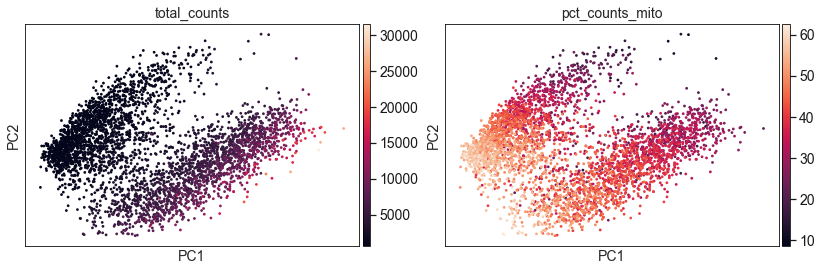

CPU times: user 17 s, sys: 1.56 s, total: 18.6 s
Wall time: 10.8 s


In [59]:
%%time
sc.tl.pca(filtered, n_comps=100) # perform PCA and plot results
sc.pl.pca(filtered, color=['total_counts','pct_counts_mito'], ncols=2)

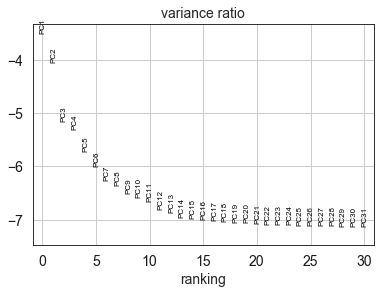

In [60]:
sc.pl.pca_variance_ratio(filtered, log=True) #examine amount of variance captured by each principal component

### Non-linear dimensionality reduction with UMAP

In [61]:
%%time
sc.pp.neighbors(filtered, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.umap(filtered, random_state=1) # perform UMAP

CPU times: user 7.8 s, sys: 186 ms, total: 7.99 s
Wall time: 7.83 s


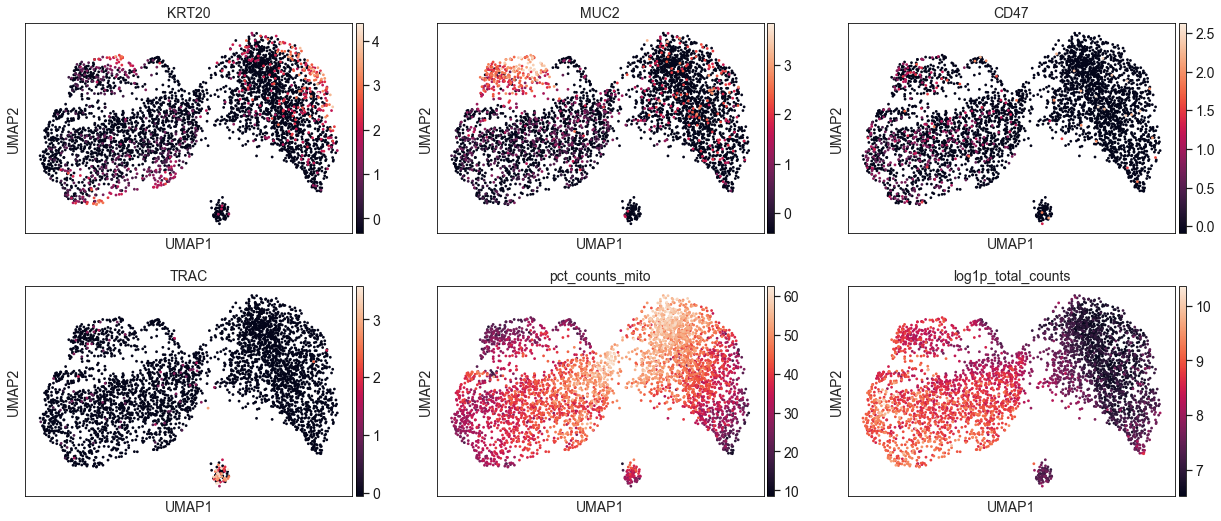

In [62]:
sc.pl.umap(filtered, color=['KRT20','MUC2','CD47','TRAC','pct_counts_mito','log1p_total_counts'], ncols=3) # plot marker genes to determine which clusters to keep or gate out

In [ ]:
s1.obs['live'] = np.where(s1.obs['percent_mito']>=0.5, 1, 0)

In [ ]:
s1.obs['live'] = np.where((s1.obs['empty']==0) & (s1.obs['dead']==0), 1, 0)

In [ ]:
s1.obs['label'] = np.where(s1.obs['live']==1, 'alive', 'dead')
s1.obs.loc[s1.obs['empty']==1,'label'] = 'empty'

---
### Machine Learning Classifiers

In [ ]:
%%time
sc.pp.normalize_total(s1) #each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1) #log1p normalization
sc.pp.scale(s1) #scaling by variance and centering to zero for visualization
sc.tl.pca(s1, n_comps=100) #performing PCA

In [ ]:
s1.obsm['X_pca'].shape

Test using wrapper function from `ml_utils.py`

In [ ]:
s1.obs['label'].unique() # order of labels for plots

In [ ]:
%%time
# Logistic Regression Classifier
lr = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial', max_iter=1000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

for train, test in cv.split(s1.obsm['X_pca'], s1.obs['label']):
    mets = multiclass_roc(clf=lr, X_train=s1.obsm['X_pca'][train], X_test=s1.obsm['X_pca'][test], y_train=s1.obs['label'][train], y_test=s1.obs['label'][test])

In [ ]:
%%time
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()

for train, test in cv.split(s1.obsm['X_pca'], s1.obs['label']):
    mets = multiclass_roc(clf=gbc, X_train=s1.obsm['X_pca'][train], X_test=s1.obsm['X_pca'][test], y_train=s1.obs['label'][train], y_test=s1.obs['label'][test])

In [ ]:
%%time
# AdaBoost Classifier
abc = AdaBoostClassifier()

for train, test in cv.split(s1.obsm['X_pca'], s1.obs['label']):
    mets = multiclass_roc(clf=abc, X_train=s1.obsm['X_pca'][train], X_test=s1.obsm['X_pca'][test], y_train=s1.obs['label'][train], y_test=s1.obs['label'][test])

---

So it looks like the __Gradient Boosting Classifier__ is our best bet based on AUROC and Accuracy values.  
Now, we can optimize the hyperparameters using `RandomizedSearchCV` to tweak the classifier for the best result and compare optimized classifier.

In [ ]:
from pprint import pprint

In [ ]:
# Generate grid of hyperparameters to test
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
loss = ['deviance', 'exponential']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# learning rate
learning_rate = np.linspace(0.1, 1, 10)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'loss': loss,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate}
pprint(random_grid)

In [ ]:
%%time
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gbc = GradientBoostingClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=18, n_jobs = -1)
# Fit the random search model
gbc_random.fit(s1.obsm['X_pca'], s1.obs['alive'])

In [ ]:
gbc_random.best_params_

In [ ]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features='auto', max_depth=70, loss='exponential', learning_rate=0.3)
mets = roc_kfold(clf=gbc, X=s1.obsm['X_pca'], y=s1.obs['alive'], k=5, seed=18)